# Introduction

This notebook will illustrate experiments with the Adam optimizer in TensorFlow to solve the `pde_03` 2-D PDE IVP.

## The `pde_03` PDE problem

This PDE was created as a sanity check for the code. The differential equation is provided in the form:

\begin{equation}
    \frac {\partial \psi} {\partial x} + \frac {\partial \psi} {\partial y} = x + y
\end{equation}

or:

\begin{equation}
    G \left( x, y, \psi, \frac {\partial \psi} {dx}, \frac {\partial \psi} {\partial y} \right) = \frac {\partial \psi} {\partial x} + \frac {\partial \psi} {dy} - x - y = 0
\end{equation}

with initial conditions:

\begin{equation}
    f_0(0, y) = \psi(0, y) = 0 \\
    g_0(x, 0) = \psi(x, 0) = 0 \\
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x, y) = x y
\end{equation}

The derivatives are:

\begin{equation}
    \frac {\partial \psi} {\partial x} = y \\
    \frac {\partial \psi} {\partial y} = x \\
\end{equation}

The analytical solution in the domain $0 \leq x,y \leq 1$ is plotted below.

In [14]:
# Import standard Python modules.
import datetime
import importlib
from itertools import repeat
from math import exp
import os
import platform
import sys

# Import 3rd-party modules.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import TensorFlow.
import tensorflow as tf

In [15]:
# Use 64-bit math in TensorFlow.
tf.keras.backend.set_floatx('float64')

In [16]:
class Equation:
    name = "pde03"

    @staticmethod
    def G(xy, Y, delY, del2Y):
        """Differential equation in standard form."""
        (x, y) = xy
        (dY_dx, dY_dy) = delY
        _G = dY_dx + dY_dy - x - y
        return _G

    @staticmethod
    def f0(xy):
        """Boundary condition at (x, y) = (0, y)."""
        return 0

    @staticmethod
    def g0(xy):
        """Boundary condition at (x, y) = (x, 0)."""
        return 0

    @staticmethod
    def Ya(xy):
        """Analytical solution."""
        (x, y) = xy
        _Ya = x*y
        return _Ya

    @staticmethod
    def dYa_dx(xy):
        """Analytical dY/dx."""
        (x, y) = xy
        _dYa_dx = y
        return _dYa_dx

    @staticmethod
    def dYa_dy(xy):
        """Analytical dY/dy."""
        (x, y) = xy
        _dYa_dy = x
        return _dYa_dy

eq = Equation()

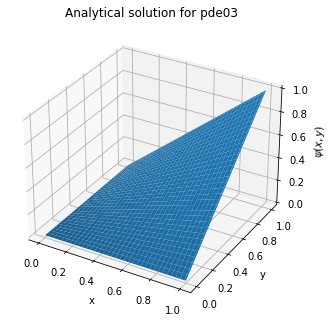

In [17]:
# Compute the analytical solution.
na = 101
xa = np.linspace(0, 1, na)
ya = np.linspace(0, 1, na)
Ya = [[eq.Ya([x, y]) for y in ya] for x in xa]
Ya = np.array(Ya)

# Plot the analytical solution.
fig = plt.figure()
(X, Y) = np.meshgrid(xa, ya)
Z = Ya.T
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\psi(x,y)$')
plt.title("Analytical solution for %s" % eq.name)
plt.show()

## Solving `pde_03` using TensorFlow

In [18]:
def print_system_information():
    print("System report:")
    print(datetime.datetime.now())
    print("Host name: %s" % platform.node())
    print("OS: %s" % platform.platform())
    print("uname:", platform.uname())
    print("Python version: %s" % sys.version)
    print("Python build:", platform.python_build())
    print("Python compiler: %s" % platform.python_compiler())
    print("Python implementation: %s" % platform.python_implementation())
    # print("Python file: %s" % __file__)

In [19]:
def create_output_directory(path=None):
    path_noext, ext = os.path.splitext(path)
    output_dir = path_noext
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return output_dir

In [20]:
def prod(n: list) -> int:
    """Compute the product of the elements of a list of numbers."""
    p = 1
    for nn in n:
        p *= nn
    return p

def create_training_grid2(*shape):
    """Create a grid of training data."""

    # Determine the number of dimensions in the result.
    m = len(shape)

    # Handle 1-D and (n>1)-D cases differently.
    if m == 1:
        n = shape[0]
        X = [i/(n - 1) for i in range(n)]
    else:
        # Compute the evenly-spaced points along each dimension.
        x = [[i/(n - 1) for i in range(n)] for n in shape]

        # Assemble all possible point combinations.
        X = []
        p1 = None
        p2 = 1
        for j in range(m - 1):
            p1 = prod(shape[j + 1:])
            XX = [xx for item in x[j] for xx in repeat(item, p1)]*p2
            X.append(XX)
            p2 *= shape[j]
        X.append(x[-1]*p2)
        X = list(zip(*X))

    # Return the list of training points.
    return X

def create_training_data(*n_train):
    x_train = np.array(create_training_grid2(*n_train))
    return x_train

In [94]:
def build_model(H, w0_range, u0_range, v0_range):
    hidden_layer_1 = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
        bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
        use_bias=False,
    )
    model = tf.keras.Sequential([hidden_layer_1, output_layer])
    return model

In [95]:
print_system_information()

System report:
2021-11-15 16:24:18.507872
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Mon Aug 30 06:12:21 PDT 2021; root:xnu-7195.141.6~3/RELEASE_X86_64', machine='x86_64', processor='i386')
Python version: 3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]
Python build: ('default', 'Oct 12 2021 06:23:56')
Python compiler: Clang 10.0.0 
Python implementation: CPython


In [104]:
# Define the hyperparameters.

# Set up the output directory.
path = "./pde_03"
output_dir = create_output_directory(path)

# Training optimizer
training_algorithm = "Adam"

# Initial parameter ranges
w0_range = [-0.1, 0.1]
u0_range = [-0.1, 0.1]
v0_range = [-0.1, 0.1]

# Number of hidden nodes.
H = 20

# Number of training points in each dimension.
nx_train = 11
ny_train = 11
n_train = nx_train*ny_train

# Number of training epochs.
n_epochs = 1000

# Learning rate.
learning_rate = 0.01

# Relative tolerance for consecutive loss function values to indicate convergence.
tol = 1e-4

# Random number generator seed.
random_seed = 0

In [105]:
# Create and save the training data.
xy_train = create_training_data(nx_train, ny_train)
x_train = xy_train[::ny_train, 0]
y_train = xy_train[:ny_train, 1]
np.savetxt(os.path.join(output_dir,'xy_train.dat'), xy_train)

In [108]:
# Build the model.
model = build_model(H, w0_range, u0_range, v0_range)

# Create the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [109]:
# Train the model.

# Create history variables.
losses = []
phist = []

# Set the random number seed for reproducibility.
tf.random.set_seed(random_seed)

# Rename the training data Variable (_v) for convenience, just for training.
xy_train_v = tf.Variable(xy_train, name="xy_train")
xy = xy_train_v

converged = False

print("Hyperparameters: n_train = %s, H = %s, n_epochs = %s, learning_rate = %s"
      % (n_train, H, n_epochs, learning_rate))
t_start = datetime.datetime.now()
print("Training started at", t_start)

for epoch in range(n_epochs):
    # if epoch % 100 == 0:
    #     print("Starting epoch %d." % epoch)

    # Run the forward pass.
    with tf.GradientTape(persistent=True) as tape2:
        with tf.GradientTape(persistent=True) as tape1:

            # Change notation for convenience.
            x = xy[:, 0]
            y = xy[:, 1]

            # Compute the network output.
            N = model(xy)

            # Compute the trial solution.
            A = 0
            P = x*y
            Y = A + P*N[:, 0]

        # Compute the gradient of the trial solution wrt inputs.
        dY_dx = tape1.gradient(Y, x)
        dY_dy = tape1.gradient(Y, y)

        # Compute the estimates of the differential equations.
        G = dY_dx + dY_dy - x - y

        # Compute the loss function.
        L = tf.math.sqrt(tf.reduce_sum(G**2)/n_train)

    # Save the current losses.
    losses.append(L.numpy())

    # Check for convergence.
    if epoch > 0:
        # Y_delta = np.abs(Y.numpy() - Y_old)
        # max_delta = Y_delta.max()
        loss_delta = (losses[-1] - losses[-2])/losses[-2]
        if abs(loss_delta) <= tol:
            converged = True
            break
        # if Y_delta.max() <= tol:
        #     converged = True
        #     break

    # Compute the gradient of the loss function wrt the network parameters.
    pgrad = tape2.gradient(L, model.trainable_variables)

    # Save the parameters used in this pass.
    phist.append(
        np.hstack(
            (model.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
             model.trainable_variables[1].numpy(),       # u (H,) row vector
             model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )

    # Update the parameters for this pass.
    optimizer.apply_gradients(zip(pgrad, model.trainable_variables))

    if epoch % 100 == 0:
        print("Ending epoch %s, loss function = %s" % (epoch, L.numpy()))

# Save the parameters used in the last pass.
phist.append(
    np.hstack(
        (model.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
         model.trainable_variables[1].numpy(),       # u (H,) row vector
         model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
    )
)

t_stop = datetime.datetime.now()
print("Training stopped at", t_stop)
t_elapsed = t_stop - t_start
print("Total training time was %s seconds." % t_elapsed.total_seconds())
print("Epochs: %d" % (epoch + 1))
print("Final value of loss function: %f" % losses[-1])
print("converged = %s" % converged)

# Save the parameter histories.
np.savetxt(os.path.join(output_dir, 'phist.dat'), np.array(phist))

Hyperparameters: n_train = 121, H = 20, n_epochs = 1000, learning_rate = 0.01
Training started at 2021-11-15 16:25:22.185539
Ending epoch 0, loss function = 1.0324410371123114
Ending epoch 100, loss function = 0.006596629497206658
Ending epoch 200, loss function = 0.02161741251443991
Ending epoch 300, loss function = 0.0007133801542388938
Ending epoch 400, loss function = 0.0032994638651620994
Ending epoch 500, loss function = 0.020288868820860662
Ending epoch 600, loss function = 0.001034528808242481
Ending epoch 700, loss function = 0.0034927935421261262
Ending epoch 800, loss function = 0.019160776285069247
Ending epoch 900, loss function = 0.001259801173897558
Training stopped at 2021-11-15 16:25:29.390471
Total training time was 7.204932 seconds.
Epochs: 1000
Final value of loss function: 0.012245
converged = False


In [88]:
# Compute and save the trained results at training points.
with tf.GradientTape(persistent=True) as tape1:
    N = model(xy)
    A = 0
    P = x*y
    Yt_train = A + P*N[:, 0]
dYt_dx_train = tape1.gradient(Yt_train, xy)
np.savetxt(os.path.join(output_dir, 'Yt_train.dat'), Yt_train.numpy().reshape((n_train)))
np.savetxt(os.path.join(output_dir, 'dYt_dx_train.dat'), dYt_dx_train[:, 0].numpy().reshape((n_train)))
np.savetxt(os.path.join(output_dir, 'dYt_dy_train.dat'), dYt_dx_train[:, 1].numpy().reshape((n_train)))

# Compute and save the analytical solution and derivative at training points.
Ya_train = np.array([eq.Ya(xy) for xy in xy_train])
np.savetxt(os.path.join(output_dir,'Ya_train.dat'), Ya_train)
dYa_dx_train = np.array([eq.dYa_dx(xy) for xy in xy_train])
dYa_dy_train = np.array([eq.dYa_dy(xy) for xy in xy_train])
np.savetxt(os.path.join(output_dir,'dYa_dx_train.dat'), dYa_dx_train)
np.savetxt(os.path.join(output_dir,'dYa_dy_train.dat'), dYa_dy_train)

# Compute and save the error in the trained solution and derivatives at training points.
Yt_err_train = Yt_train.numpy().reshape((n_train)) - Ya_train
np.savetxt(os.path.join(output_dir, 'Yt_err_train.dat'), Yt_err_train)
dYt_dx_err_train = dYt_dx_train[:, 0].numpy().reshape((n_train)) - dYa_dx_train
dYt_dy_err_train = dYt_dx_train[:, 1].numpy().reshape((n_train)) - dYa_dy_train
np.savetxt(os.path.join(output_dir, 'dYt_dx_err_train.dat'), dYt_dx_err_train)
np.savetxt(os.path.join(output_dir, 'dYt_dy_err_train.dat'), dYt_dy_err_train)

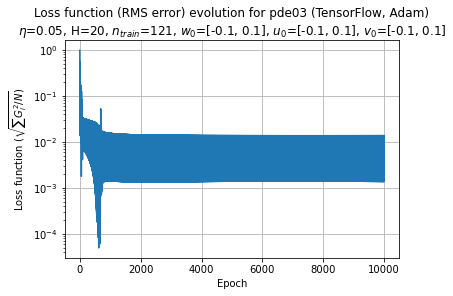

In [89]:
# Plot the loss function history.
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sqrt {\sum G_i^2/N}$)")
plt.grid()
plt.title("Loss function (RMS error) evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_{train}$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq.name, 'TensorFlow', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.show()

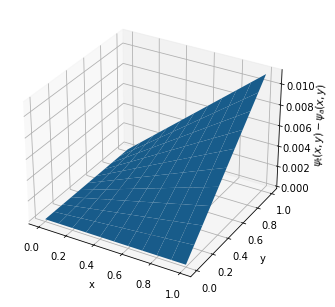

In [90]:
# Plot the error in the trained solution at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
Z = Yt_err_train.reshape((ny_train, nx_train))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\psi_t(x,y)-\psi_a(x,y)$')
plt.show()

In [91]:
# At this point, Z contains the errors in training point order.

# The rows correspond to increasing values of x,
# and the columns to increasing values of y,
# i.e. the coordinate origin (x=0, y=0) is in the upper-left corner
# of the array when printed in the usual fashion.
Z = Yt_err_train.reshape((nx_train, ny_train))

# Now flip the data vertically so that the rows are in *decreasing* x order.
# This puts the origin in the lower left corner, but with rows
# for x and columns for y (so we need to transpose).
Z = np.flip(Z, axis=0)

# Finally, transpose the array. The origin remains in the lower-left
# corner, but now the horizontal (column) axis is x, and the
# vertical (row) axis is y, as needed for the heat map.
Z = Z.T

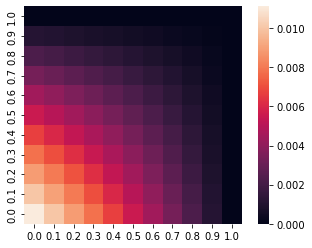

In [92]:
# Plot the error in the trained solution at the training points.
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train), square=True)

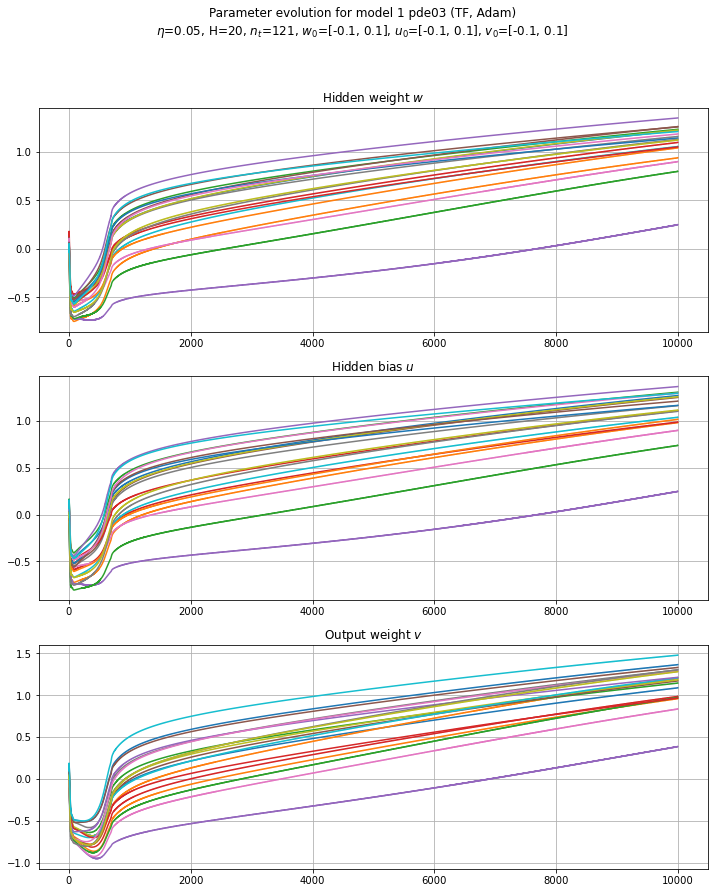

In [93]:
# Plot the parameter histories for model 1.
phist = np.array(phist)
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for model 1 %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq.name, 'TF', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.subplots_adjust(hspace=0.2)
plt.show()